# Acceleration as a function of Time on Equator

In [1]:
%config InlineBackend.figure_format = 'retina'
InteractiveShell.ast_node_interactivity = 'last_expr' 

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
from astropy import units as u
from astropy import constants as c
from itertools import product
import yssbtmpy_ana2021 as tm

from matplotlib import pyplot as plt
from matplotlib import rcParams

from accutil import (set_perpmodel, set_phaethon, set_model_aspect,
                     linticker, logxticker, logyticker, CHEMDICT,
                    QprbarSpline, QprbarSunSpline, QPRDIR)

FIGDIR = Path("./figs")

TPM_PERP = dict(rot_period=6*u.h, 
                r_hel=0.2*u.au,
                a_bond=0.1, 
                ti=200, 
                bulk_mass_den=2000*u.kg/u.m**3, 
                emissivity=0.90,
                nlon=360,
                nlat=3)

In [3]:
# We need to do it in a separate cell. See:
# https://github.com/jupyter/notebook/issues/3385
plt.style.use('default')
rcParams.update({'font.size':12})

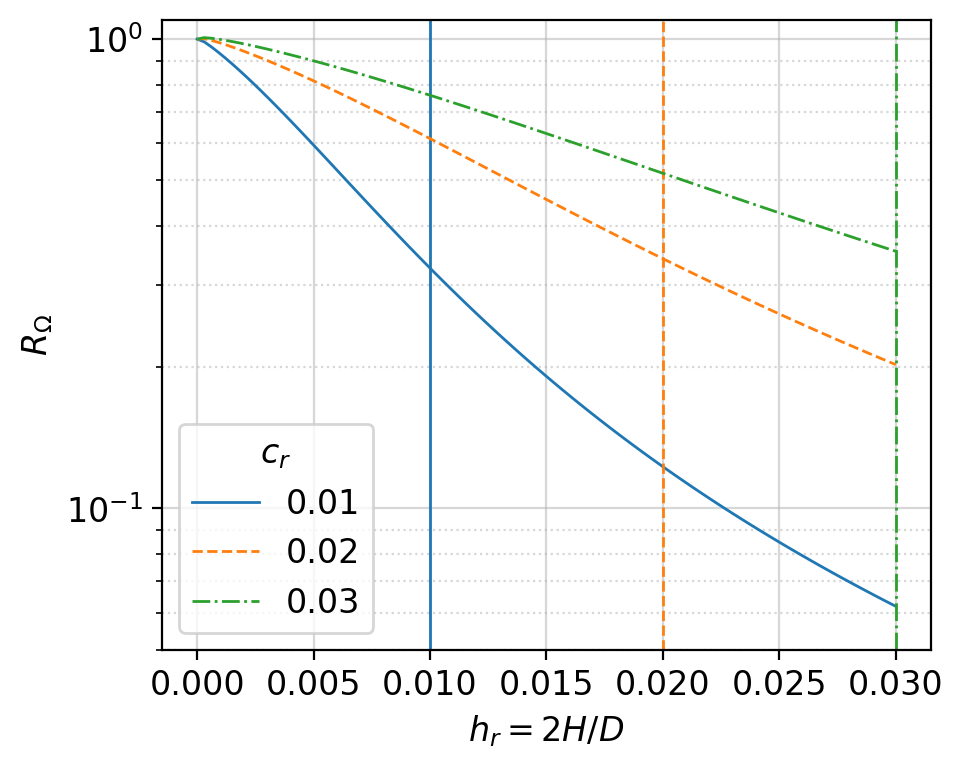

In [4]:
# Omega-ratio
def r_omega(c_r, h_r):
    omega_pat = 1 - np.cos(np.arctan(c_r/(h_r)))
    omega_ast = 1 - np.sqrt(1 - 1/(1 + h_r))
    return omega_pat / omega_ast


fig, axs = plt.subplots(1, 1, figsize=(5, 4), 
                        sharex=False, sharey=False, gridspec_kw=None)

ax = axs
h_rs = np.linspace(0, 0.03, 100)
for c_r, ls in zip([0.01, 0.02, 0.03], ['-', '--', '-.']):
    l, = ax.plot(h_rs, r_omega(c_r, h_rs), label=c_r, ls=ls, lw=1)
    ax.axvline(c_r, color=l.get_color(), lw=1, ls=ls)
ax.set(
    xlim=ax.get_xlim(),
    ylim=(5.e-2, 1.1),
    xscale='linear',
    yscale='log',
    xlabel=r"$h_r = 2H/D$",
    ylabel=r"$R_\Omega$",
    title=""
)
linticker(axs)
ax.legend(title=r"$c_r$")
plt.tight_layout()
fig.align_ylabels(axs)
fig.align_xlabels(axs)

plt.savefig(FIGDIR/"omega_ratio.png", dpi=300, bbox_inches="tight")
plt.savefig(FIGDIR/"omega_ratio.pdf", bbox_inches="tight")

plt.show()

## Combined

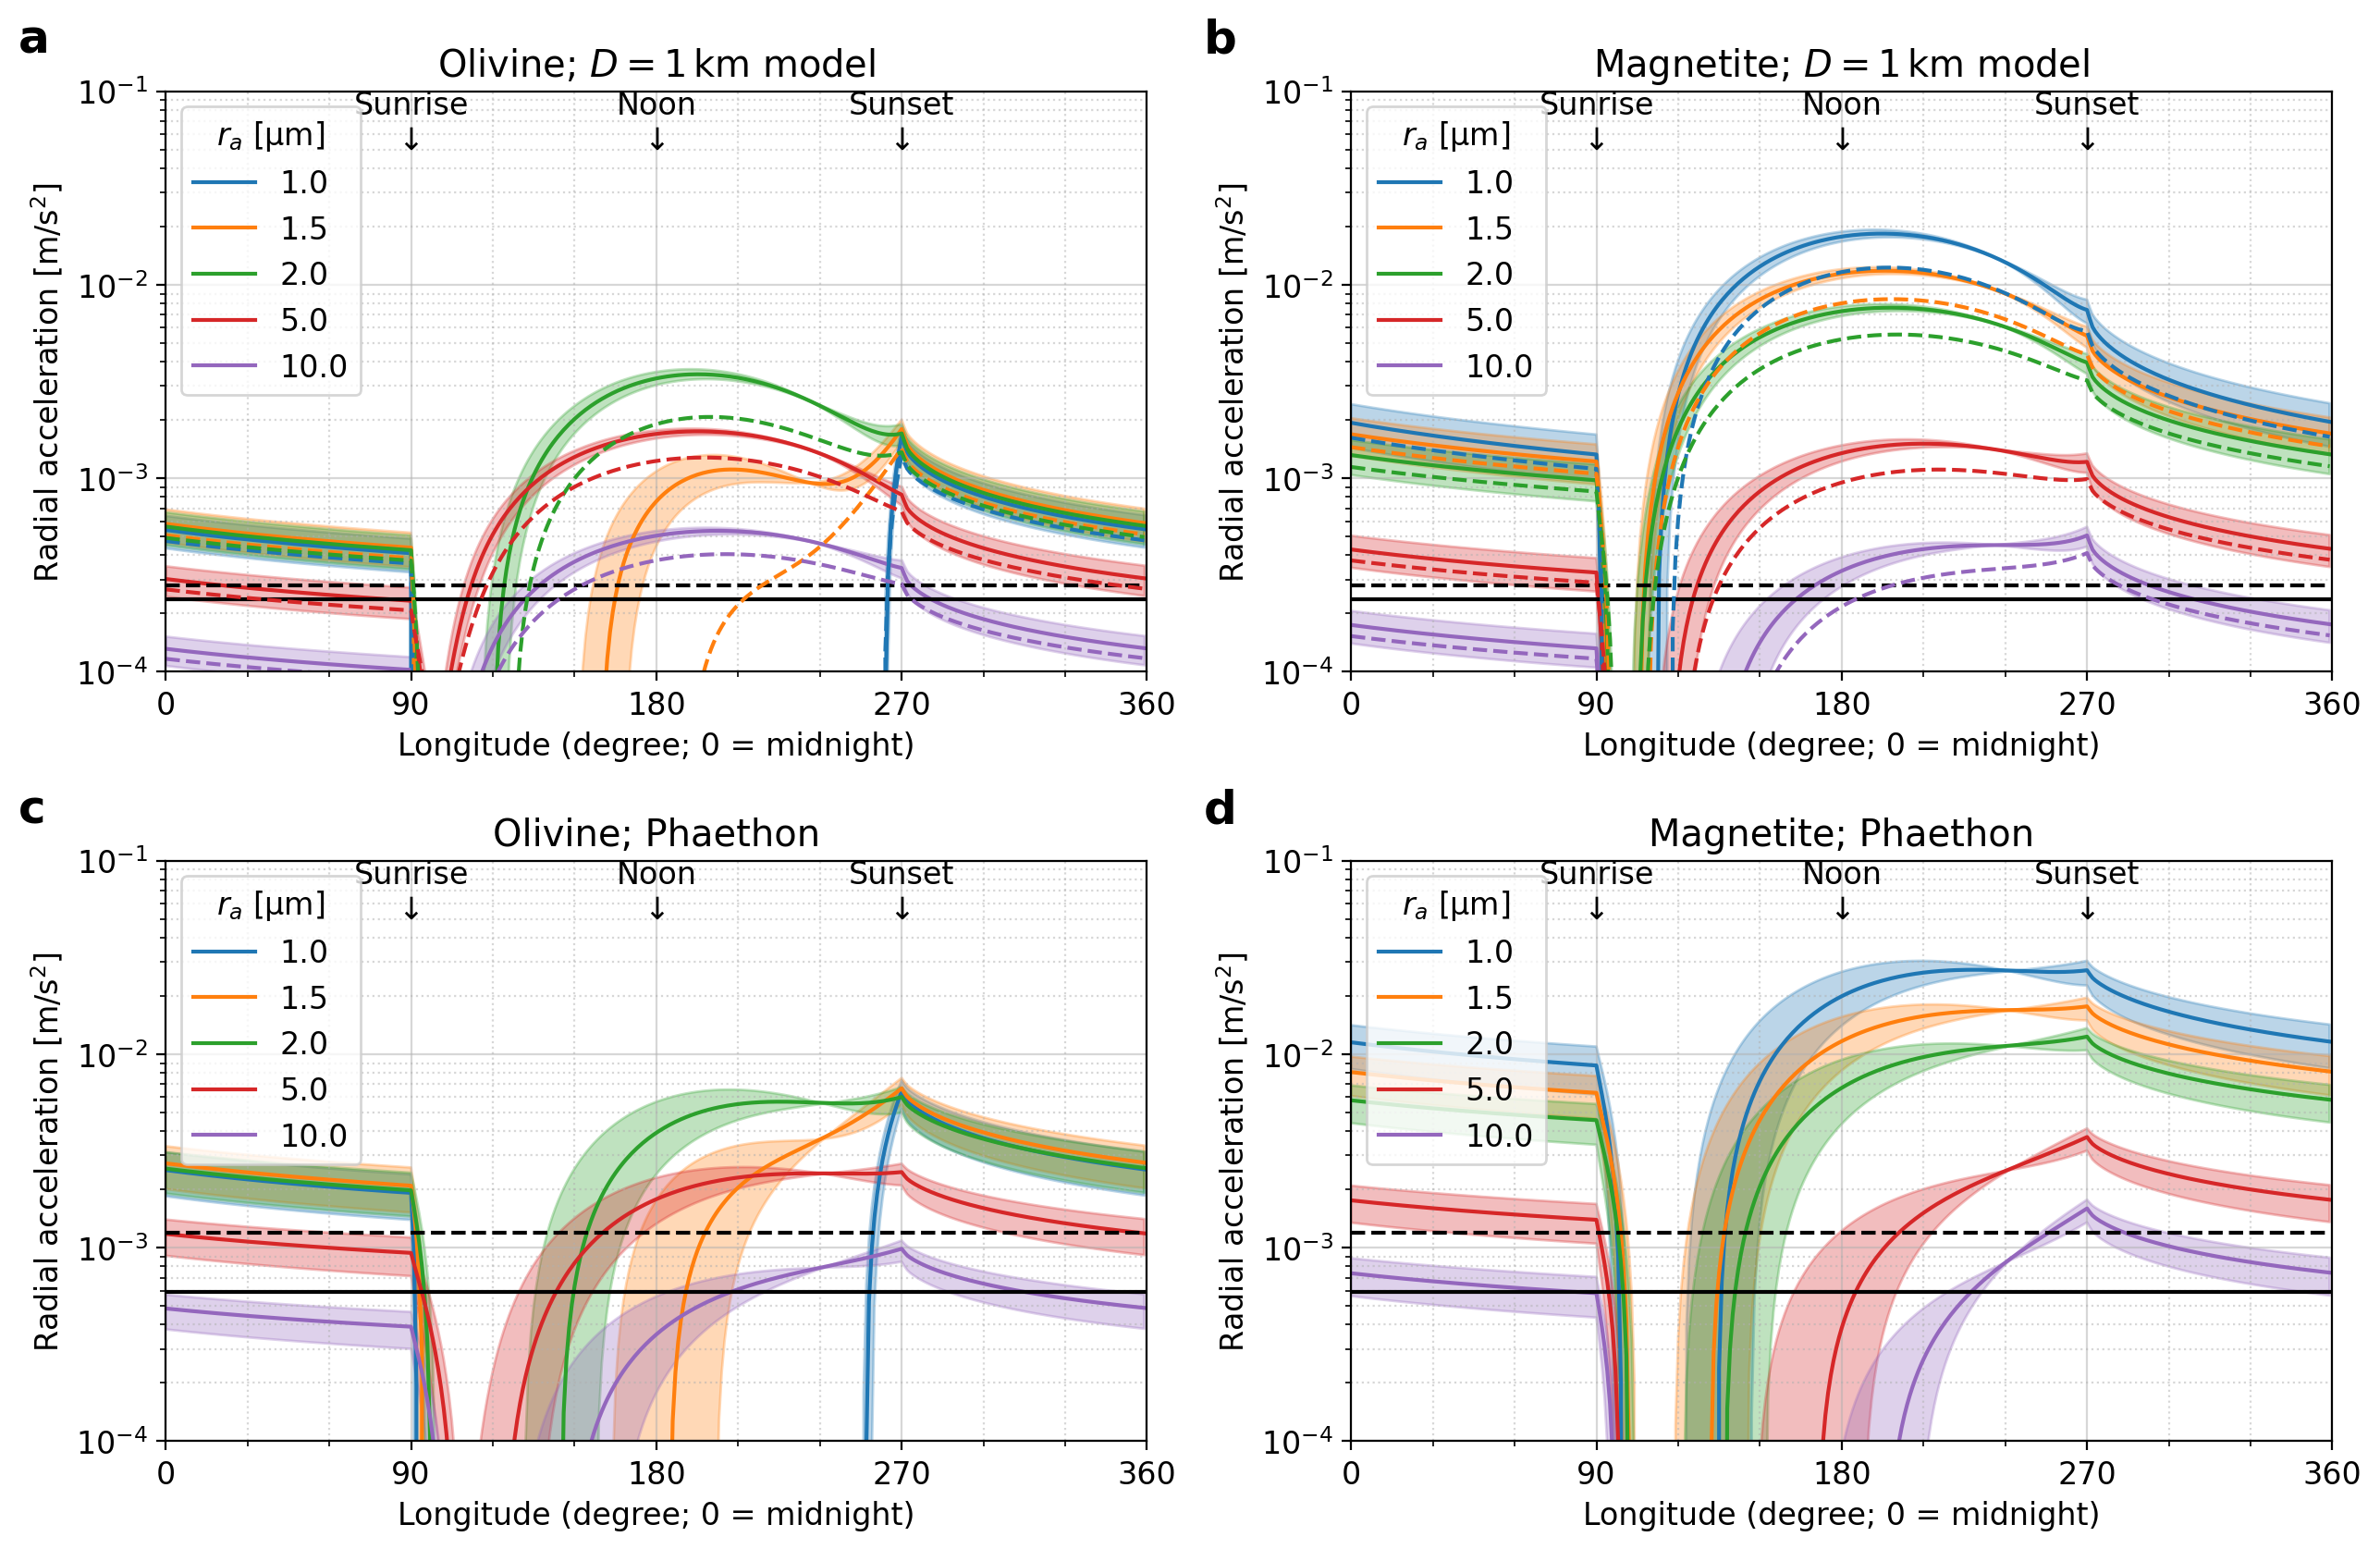

In [5]:
ti_factor = (0.2**-0.75, 0.14**-0.75)
# ti_factor = (1, 1)

TPM_PERP = dict(rot_period=6*u.h, 
                r_hel=0.2*u.au,
                a_bond=0.05, 
                ti=200, 
                bulk_mass_den=2000*u.kg/u.m**3, 
                emissivity=0.90,
                nlon=360,
                nlat=3)

perpmodel = set_perpmodel(diam_eff=1*u.km, **TPM_PERP)
th45model = set_model_aspect(diam_eff=1*u.km, **TPM_PERP, aspect_deg=45)
phaemodel = set_phaethon(true_anom=0)
# perpmodel.calc_temp(full=False)
# phaemodel.calc_temp(full=False)

def setting_ax(ax):
    linticker(ax, 
             xmajlockws=90, xminlockws=30,
             ymajlockws=1, yminlockws=1,
             xmajfmtkws="%.0f",
             ymajfmtkws="",
             )
    ax.set(ylim=(1.e-4, 1.e-1), 
           xlim=(0, 360),
           yscale='log',
           xlabel="Longitude (degree; 0 = midnight)",
           ylabel=r"Radial acceleration [$\mathrm{m/s^2}$]"
          )
    ax.text(90, 0.05, "Sunrise\n↓", horizontalalignment='center')
    ax.text(180, 0.05, "Noon\n↓", horizontalalignment='center')
    ax.text(270, 0.05, "Sunset\n↓", horizontalalignment='center')
    ax.legend(title="$r_a$ [µm]", loc='upper left')
    
    
# dphi, a_grav, a_cent are identical for perp and th45 models.
dphi = np.rad2deg(phaemodel.dlon)
phis = np.arange(0, 360 - dphi/2, dphi)

a_grav = (tm.GG_Q * perpmodel.mass / (perpmodel.diam_eff/2)**2).to(u.m/u.s**2)
a_cent = perpmodel.rot_omega**2*perpmodel.diam_eff/2

lss = ['-', '--']
tis = {0:[200, 150, 250], 1:[200]}

fig, axs = plt.subplots(2, 2, figsize=(13, 8.5))

for i_ax, (chem, chemname) in enumerate(CHEMDICT.items()):
    Qprbar_sun = QprbarSunSpline(QPRDIR/f"Qprbar_sun_{chem}.csv")
    Qprbar_ther = QprbarSpline(QPRDIR/f"Qprbar_{chem}.csv")

    for i_m, model in enumerate([perpmodel, th45model]):
        ax = axs[0][i_ax]
        detail = len(tis[i_m]) > 1

        for i_r, radius in enumerate([1, 1.5, 2, 5, 10]):
            color = plt.cm.tab10(i_r)
            a_sun_r = np.zeros((phis.shape[0], 3), dtype=float)
            a_ref_r = np.zeros((phis.shape[0], 3), dtype=float)
            a_ther_r = np.zeros((phis.shape[0], 3), dtype=float)

            for i, ti in enumerate(tis[i_m]):
                ti = ti_factor[0]*ti
                model.set_thermal(ti=ti, emissivity=TPM_PERP["emissivity"])
                model.calc_temp()
                particle = tm.MovingParticle(smallbody=model,
                                             radius=radius*u.um,
                                             mass_den=3000*u.kg/u.m**3)
                particle.set_func_Qprbar(func_Qprbar=Qprbar_ther.get_value,
                                         func_Qprbar_sun=Qprbar_sun.get_value)

                for j, phi in enumerate(phis):
                    particle.set_initial_pos(90, phi, height=1*u.cm)
                    r_unit = particle.trace_rvec[0]
                    a_sun_r[j, i] = np.dot(r_unit, particle.trace_a_sun_xyz[0])
                    a_ref_r[j, i] = np.dot(r_unit, particle.trace_a_ref_xyz[0])
                    a_ther_r[j, i] = np.dot(r_unit, particle.trace_a_ther_xyz[0])

            a_sum = a_ther_r + a_ref_r + a_sun_r
            a_min = a_sum.min(axis=1)
            a_max = a_sum.max(axis=1)

            if detail:
                ax.fill_between(phis, a_min, a_max, color=color, alpha=0.3)
                label = "{:.1f}".format(radius)
            else:
                label = None
            ax.plot(phis, a_sum[:, 0], color=color, ls=lss[i_m], label=label)

        if detail:
#             ax.axhline(a_grav.value, color='k', ls='--', label="Grav")
#             ax.axhline((a_grav - a_cent).value, color='k', ls='-', label="Grav - Cent")
            ax.axhline(a_grav.value, color='k', ls='--')
            ax.axhline((a_grav - a_cent).value, color='k', ls='-')
        
a_grav = (tm.GG_Q * phaemodel.mass / (phaemodel.diam_eff/2)**2).to(u.m/u.s**2)
a_cent = phaemodel.rot_omega**2*phaemodel.diam_eff/2

lss = ['-', '--']
tis = {0:[600, 400, 800], 1:[600]}

for i_ax, (chem, chemname) in enumerate(CHEMDICT.items()):
    Qprbar_sun = QprbarSunSpline(QPRDIR/f"Qprbar_sun_{chem}.csv")
    Qprbar_ther = QprbarSpline(QPRDIR/f"Qprbar_{chem}.csv")

    for i_m, model in enumerate([phaemodel]):
        ax = axs[1][i_ax]
        detail = len(tis[i_m]) > 1

        for i_r, radius in enumerate([1, 1.5, 2, 5, 10]):
            color = plt.cm.tab10(i_r)
            a_sun_r = np.zeros((phis.shape[0], 3), dtype=float)
            a_ref_r = np.zeros((phis.shape[0], 3), dtype=float)
            a_ther_r = np.zeros((phis.shape[0], 3), dtype=float)

            for i, ti in enumerate(tis[i_m]):
                ti = ti_factor[1]*ti
                model.set_thermal(ti=ti, emissivity=TPM_PERP["emissivity"])
                model.calc_temp()
                particle = tm.MovingParticle(smallbody=model,
                                             radius=radius*u.um,
                                             mass_den=3000*u.kg/u.m**3)
                particle.set_func_Qprbar(func_Qprbar=Qprbar_ther.get_value,
                                         func_Qprbar_sun=Qprbar_sun.get_value)

                for j, phi in enumerate(phis):
                    particle.set_initial_pos(90, phi, height=1*u.cm)
                    r_unit = particle.trace_rvec[0]
                    a_sun_r[j, i] = np.dot(r_unit, particle.trace_a_sun_xyz[0])
                    a_ref_r[j, i] = np.dot(r_unit, particle.trace_a_ref_xyz[0])
                    a_ther_r[j, i] = np.dot(r_unit, particle.trace_a_ther_xyz[0])

            a_sum = a_ther_r + a_ref_r + a_sun_r
            a_min = a_sum.min(axis=1)
            a_max = a_sum.max(axis=1)

            if detail:
                ax.fill_between(phis, a_min, a_max, color=color, alpha=0.3)
                label = r"{:.1f}".format(radius)
            else:
                label = None
            ax.plot(phis, a_sum[:, 0], color=color, ls=lss[i_m], label=label)

        if detail:
#             ax.axhline(a_grav.value, color='k', ls='--', label="Grav")
#             ax.axhline((a_grav - a_cent).value, color='k', ls='-', label="Grav - Cent")
            ax.axhline(a_grav.value, color='k', ls='--')
            ax.axhline((a_grav - a_cent).value, color='k', ls='-')

[setting_ax(ax) for ax in axs.ravel()]
        
axs[0][0].set(title="Olivine; $D = 1\,\mathrm{{km}}$ model")
axs[1][0].set(title=f"Olivine; Phaethon")
axs[0][1].set(title="Magnetite; $D = 1\,\mathrm{{km}}$ model")
axs[1][1].set(title="Magnetite; Phaethon")

for i, ax in enumerate(axs.flatten()):
    ax.text(x=-0.15, y=1.05, s=chr(ord('a') + i), transform=ax.transAxes, 
            fontsize=18, fontweight='bold', va='bottom', ha='left')

plt.tight_layout()
plt.savefig(FIGDIR / f"acc_diagram-all_ti_factor_{ti_factor[0]:.0f}_{ti_factor[1]:.0f}.png", dpi=300)
plt.savefig(FIGDIR / f"acc_diagram-all_ti_factor_{ti_factor[0]:.0f}_{ti_factor[1]:.0f}.pdf")
plt.show()

In [6]:
ti_factor * np.array([200, 600])

array([ 668.74030498, 2621.53236388])

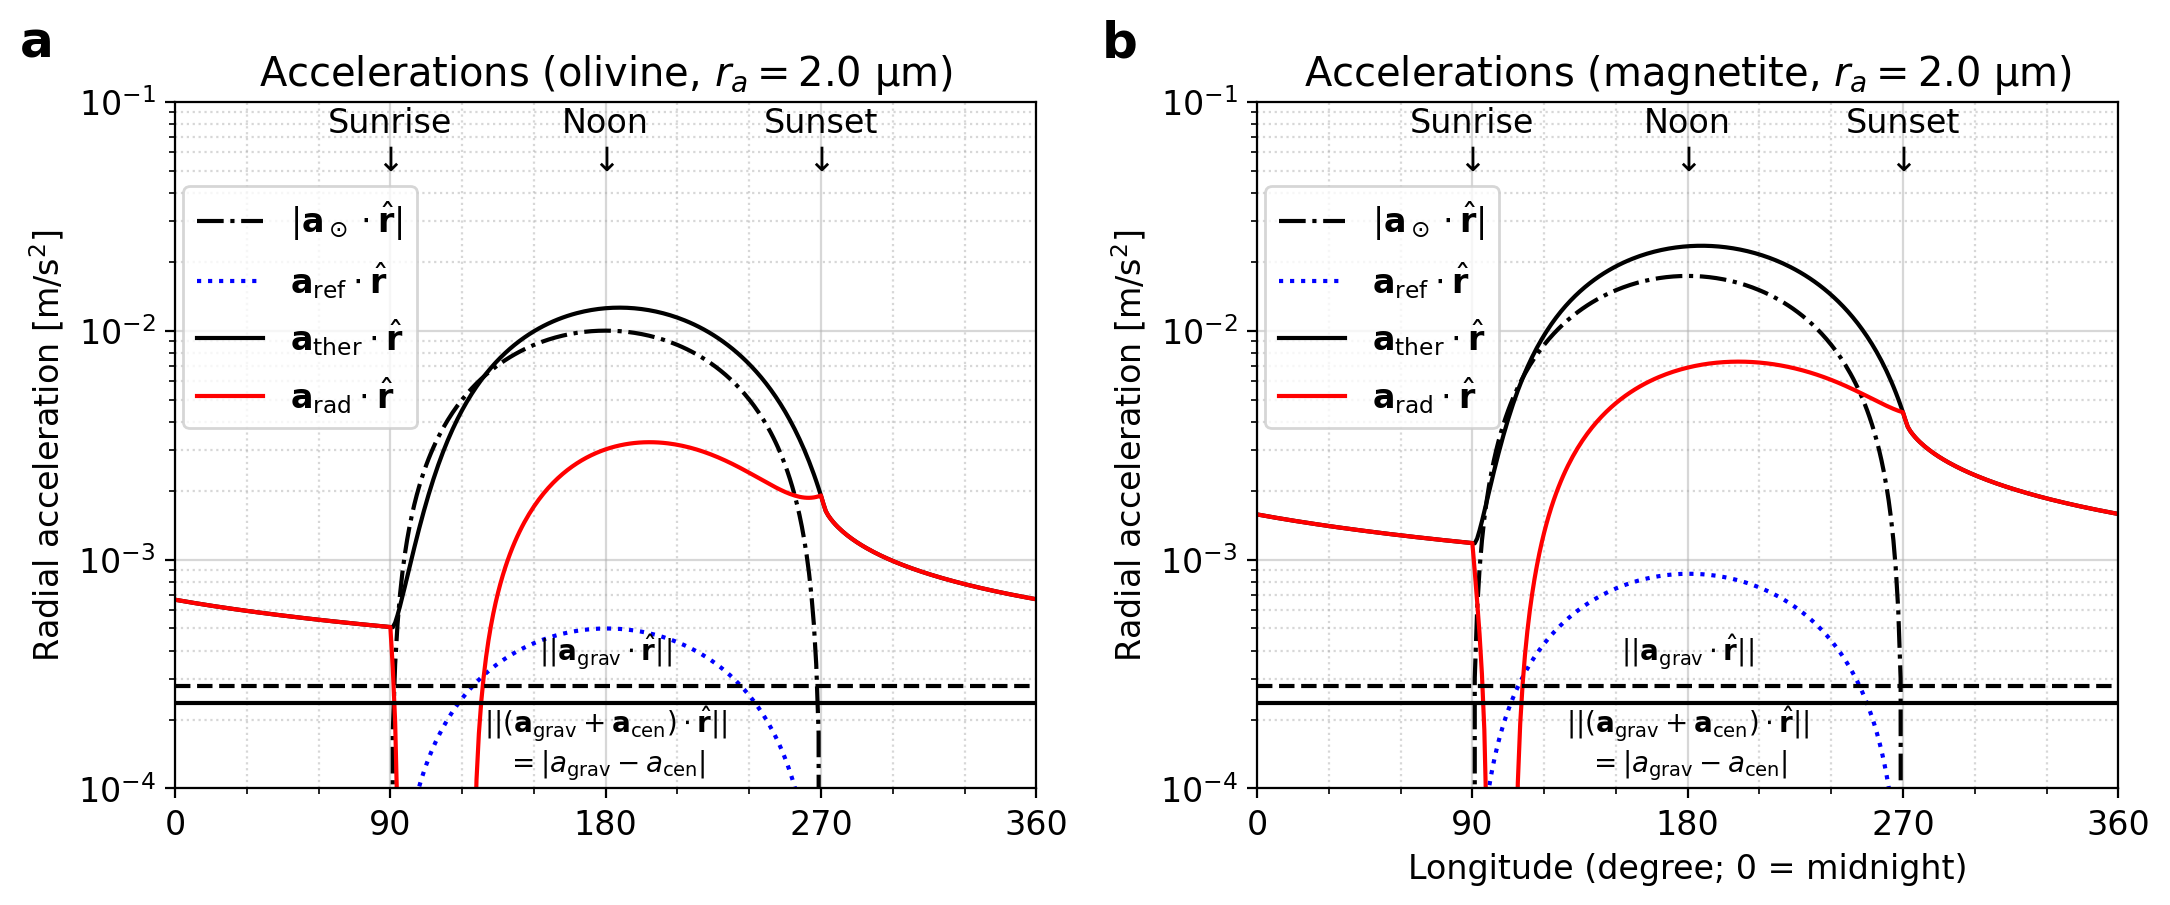

In [7]:
ti = 200
radius = 2

fig, axs = plt.subplots(1, 2, figsize=(11, 4.5), sharex=True)
# ax = axs

for i, (chem, chemname) in enumerate(CHEMDICT.items()):
    ax = axs[i]
    Qprbar_sun = QprbarSunSpline(QPRDIR/f"Qprbar_sun_{chem}.csv")
    Qprbar_ther = QprbarSpline(QPRDIR/f"Qprbar_{chem}.csv")

    particle = tm.MovingParticle(smallbody=perpmodel,
                                 radius=radius*u.um,
                                 mass_den=3000*u.kg/u.m**3)
    particle.set_func_Qprbar(func_Qprbar=Qprbar_ther.get_value,
                             func_Qprbar_sun=Qprbar_sun.get_value)

    a_sun_r = np.zeros(phis.shape[0])
    a_ref_r = np.zeros(phis.shape[0])
    a_ther_r = np.zeros(phis.shape[0])

    for j, phi in enumerate(phis):
        particle.set_initial_pos(90, phi, height=1*u.cm)
        r_unit = particle.trace_rvec[0]
        a_sun_r[j] = np.dot(r_unit, particle.trace_a_sun_xyz[0])
        a_ref_r[j] = np.dot(r_unit, particle.trace_a_ref_xyz[0])
        a_ther_r[j] = np.dot(r_unit, particle.trace_a_ther_xyz[0])

    ax.plot(phis, -1*a_sun_r, 'k-.', 
             label=r"$|\mathbf{a}_\odot \cdot \hat{\mathbf{r}}|$")
    ax.plot(phis, a_ref_r, 'b:', 
             label=r"$\mathbf{a}_\mathrm{ref} \cdot \hat{\mathbf{r}}$")
    ax.plot(phis, a_ther_r, 'k-', 
             label=r"$\mathbf{a}_\mathrm{ther} \cdot \hat{\mathbf{r}}$")
    ax.plot(phis, a_sun_r + a_ref_r + a_ther_r, 'r-',
             label=r"$ \mathbf{a}_\mathrm{rad} \cdot \hat{\mathbf{r}}$")

    a_grav = (tm.GG_Q * perpmodel.mass / (perpmodel.diam_eff/2)**2).to(u.m/u.s**2)
    a_cent = perpmodel.rot_omega**2*perpmodel.diam_eff/2

    ax.axhline(a_grav.value, color='k', ls='--')
    ax.axhline((a_grav - a_cent).value, color='k', ls='-')
    text_kw = dict(ha='center', fontsize=10)
    ax.text(180, a_grav.value*1.3, r"$|| \mathbf{a}_\mathrm{grav}\cdot \hat{\mathbf{r}} ||$", **text_kw)
    ax.text(180, (a_grav - a_cent).value*0.5, 
            (r"$ || (\mathbf{a}_\mathrm{grav} + \mathbf{a}_\mathrm{cen})\cdot \hat{\mathbf{r}} ||$"
             + "\n"
             + r"$ = |a_\mathrm{grav} - a_\mathrm{cen}| $"
            )
            , **text_kw)

    linticker(ax, 
             xmajlockws=90, xminlockws=30,
             ymajlockws=1, yminlockws=1,
             xmajfmtkws="%.0f",
             ymajfmtkws="",
             )
    ax.set(ylim=(1.e-4, 1.e-1), 
           xlim=(0, 360),
           yscale='log',
           ylabel=r"Radial acceleration [$\mathrm{m/s^2}$]",
           title=f"Accelerations ({chemname.lower()}, $r_a = ${radius:.1f} µm)"
          )
    ax.text(90, 0.05, "Sunrise\n↓", horizontalalignment='center')
    ax.text(180, 0.05, "Noon\n↓", horizontalalignment='center')
    ax.text(270, 0.05, "Sunset\n↓", horizontalalignment='center')
    ax.legend(bbox_to_anchor=(0.3, 0.5))

axs[1].set(
    xlabel="Longitude (degree; 0 = midnight)",
)
plt.tight_layout()

# axs[0].legend(bbox_to_anchor=(1, 1), ncol=1)

for i, ax in enumerate(axs.flatten()):
    ax.text(x=-0.18, y=1.05, s=chr(ord('a') + i), transform=ax.transAxes, 
            fontsize=18, fontweight='bold', va='bottom', ha='left')


plt.savefig(FIGDIR / f"perp_acc_diagram_{radius}um_decompose.png", bbox_inches="tight", dpi=200)
plt.savefig(FIGDIR / f"perp_acc_diagram_{radius}um_decompose.pdf", bbox_inches="tight")
plt.show()

## Separated
Model and Phaethon equatorial accelerations

In [8]:
perpmodel = set_perpmodel(diam_eff=1*u.km, **TPM_PERP)
th45model = set_model_aspect(diam_eff=1*u.km, **TPM_PERP, aspect_deg=45)
phaemodel = set_phaethon(true_anom=0)
perpmodel.calc_temp(full=False)
phaemodel.calc_temp(full=False)

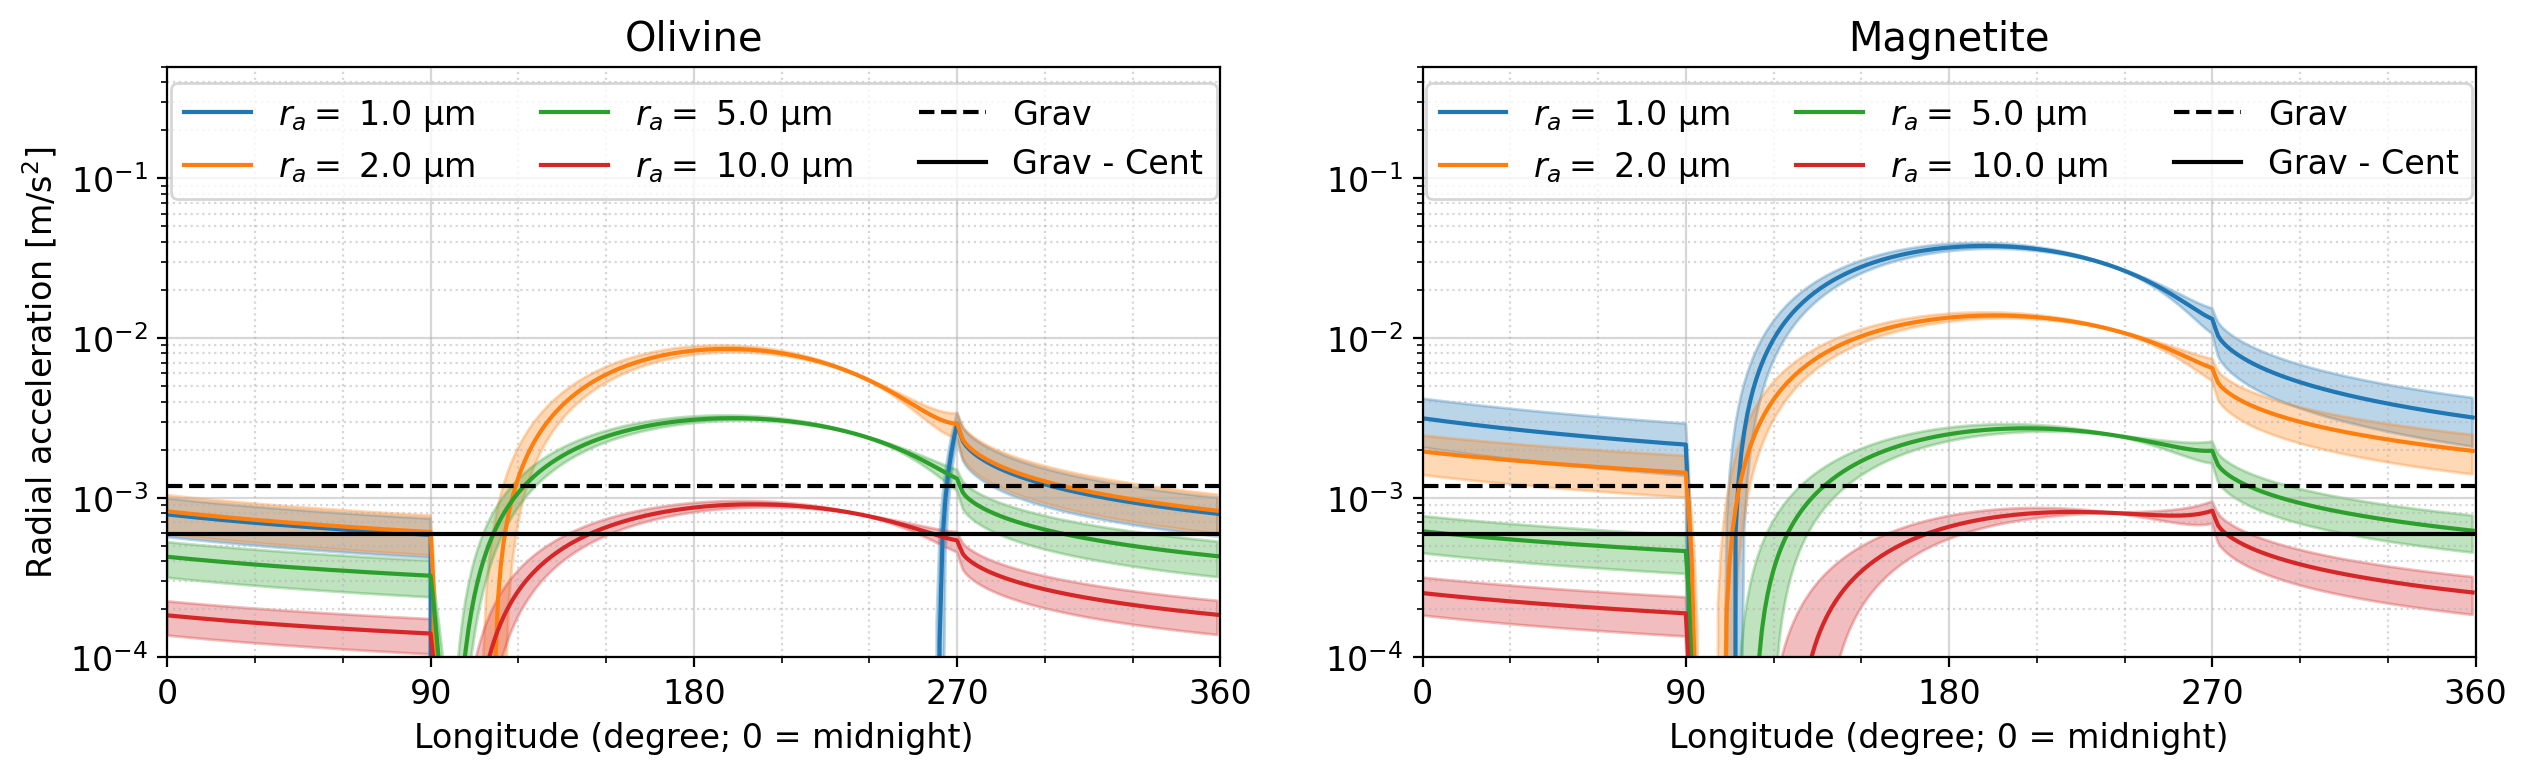

In [9]:
# dphi, a_grav, a_cent are identical for perp and th45 models.
dphi = np.rad2deg(phaemodel.dlon)
phis = np.arange(0, 360 - dphi/2, dphi)

a_grav = (tm.GG_Q * phaemodel.mass / (phaemodel.diam_eff/2)**2).to(u.m/u.s**2)
a_cent = phaemodel.rot_omega**2*phaemodel.diam_eff/2

lss = ['-', ':']
tis = {0:[600, 400, 800], 1:[600]}

fig, axs = plt.subplots(1, 2, figsize=(13, 4.))

for i_ax, (chem, chemname) in enumerate(CHEMDICT.items()):
    Qprbar_sun = QprbarSunSpline(QPRDIR/f"Qprbar_sun_{chem}.csv")
    Qprbar_ther = QprbarSpline(QPRDIR/f"Qprbar_{chem}.csv")

    for i_m, model in enumerate([phaemodel]):
        ax = axs[i_ax]
        detail = len(tis[i_m]) > 1

        for i_r, radius in enumerate([1, 2, 5, 10]):
            color = plt.cm.tab10(i_r)
            a_sun_r = np.zeros((phis.shape[0], 3), dtype=float)
            a_ref_r = np.zeros((phis.shape[0], 3), dtype=float)
            a_ther_r = np.zeros((phis.shape[0], 3), dtype=float)

            for i, ti in enumerate(tis[i_m]):
                model.set_thermal(ti=ti, emissivity=TPM_PERP["emissivity"])
                model.calc_temp()
                particle = tm.MovingParticle(smallbody=model,
                                             radius=radius*u.um,
                                             mass_den=3000*u.kg/u.m**3)
                particle.set_func_Qprbar(func_Qprbar=Qprbar_ther.get_value,
                                         func_Qprbar_sun=Qprbar_sun.get_value)

                for j, phi in enumerate(phis):
                    particle.set_initial_pos(90, phi, height=1*u.cm)
                    r_unit = particle.trace_rvec[0]
                    a_sun_r[j, i] = np.dot(r_unit, particle.trace_a_sun_xyz[0])
                    a_ref_r[j, i] = np.dot(r_unit, particle.trace_a_ref_xyz[0])
                    a_ther_r[j, i] = np.dot(r_unit, particle.trace_a_ther_xyz[0])

            a_sum = a_ther_r + a_ref_r + a_sun_r
            a_min = a_sum.min(axis=1)
            a_max = a_sum.max(axis=1)

            if detail:
                ax.fill_between(phis, a_min, a_max, color=color, alpha=0.3)
                label = r"$r_a =$ {:.1f} µm".format(radius)
            else:
                label = None
            ax.plot(phis, a_sum[:, 0], color=color, ls=lss[i_m], label=label)

        if detail:
            ax.axhline(a_grav.value, color='k', ls='--', label="Grav")
            ax.axhline((a_grav - a_cent).value, color='k', ls='-', label="Grav - Cent")

        linticker(ax, 
                 xmajlockws=90, xminlockws=30,
                 ymajlockws=1, yminlockws=1,
                 xmajfmtkws="%.0f",
                 ymajfmtkws="",
                 )
        ax.set(ylim=(1.e-4, 5.e-1), 
                xlim=(0, 360),
                yscale='log')
        ax.legend(loc='upper center', ncol=3)
        
axs[0].set(xlabel="Longitude (degree; 0 = midnight)",
           ylabel=r"Radial acceleration [$\mathrm{m/s^2}$]",
          title=f"Olivine")
axs[1].set(xlabel="Longitude (degree; 0 = midnight)", title="Magnetite")

plt.tight_layout()
plt.savefig(FIGDIR / f"phae_acc_diagram.png", dpi=300)
plt.savefig(FIGDIR / f"phae_acc_diagram.pdf")
plt.show()

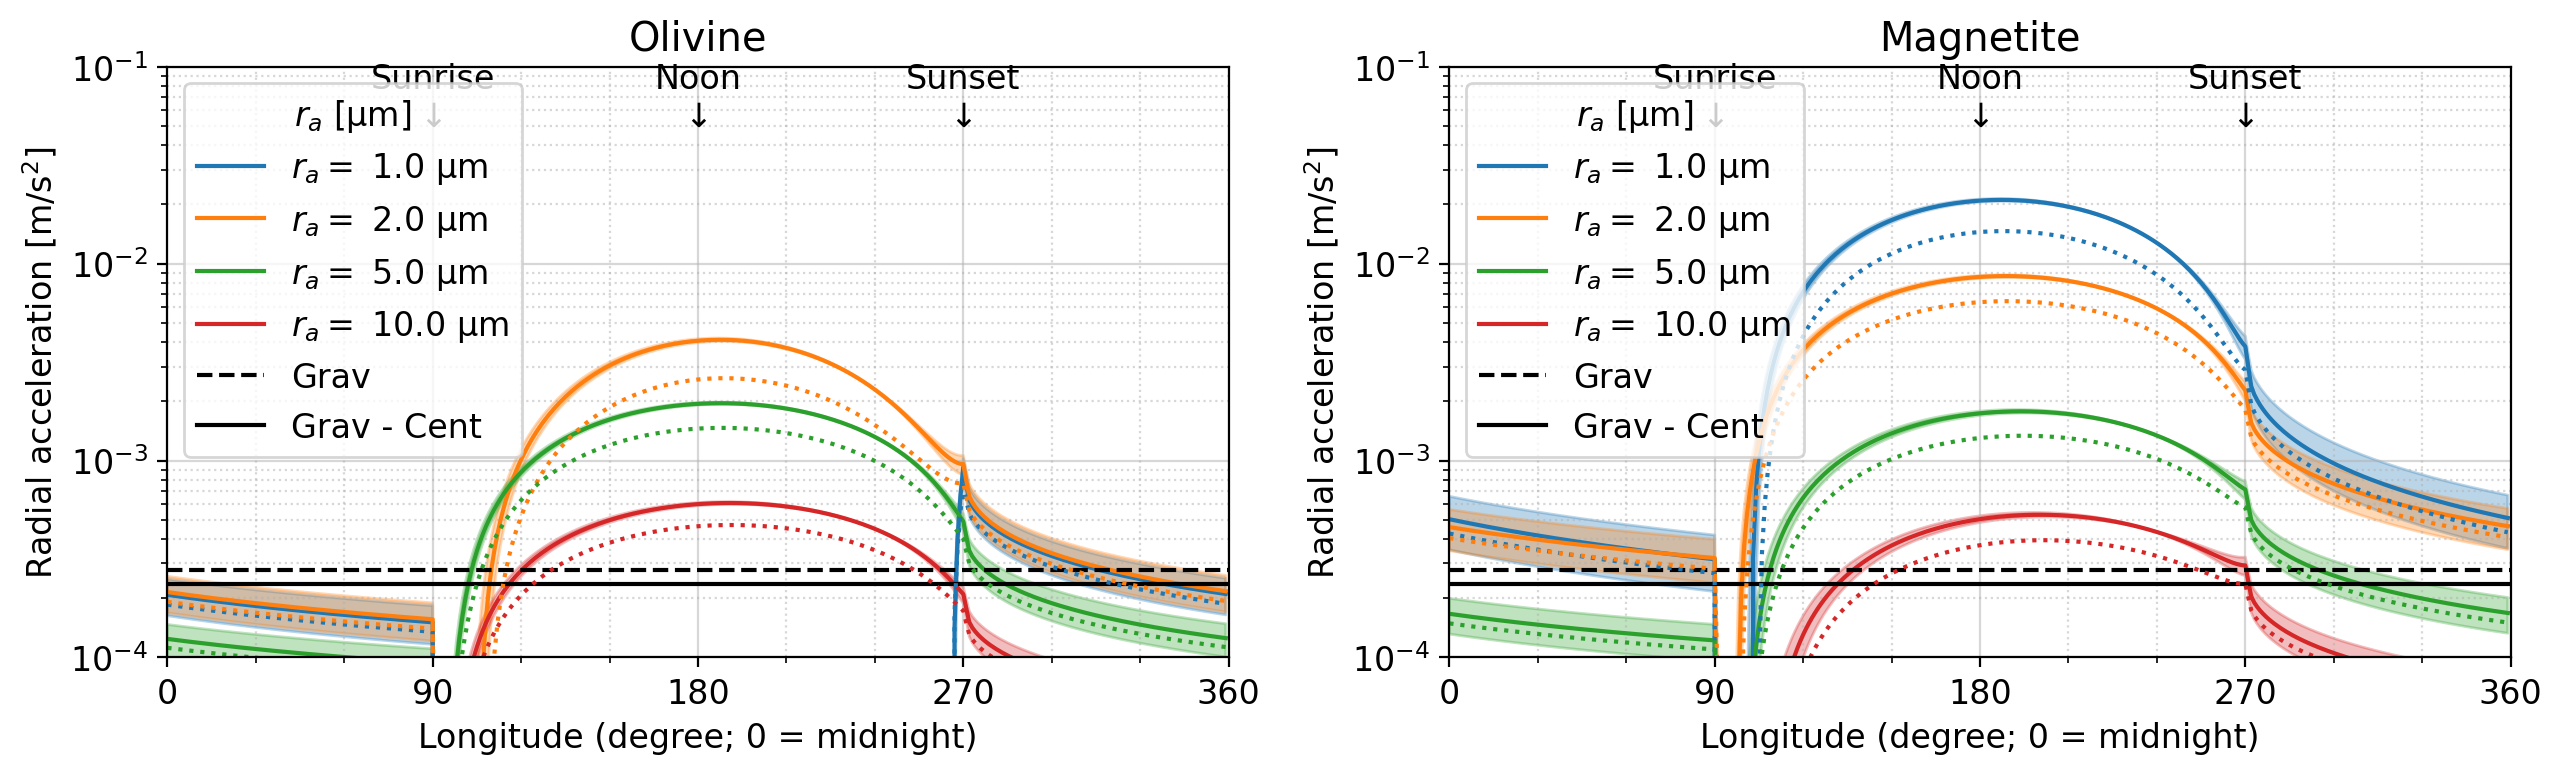

In [10]:
# dphi, a_grav, a_cent are identical for perp and th45 models.
dphi = np.rad2deg(perpmodel.dlon)
phis = np.arange(0, 360 - dphi/2, dphi)

a_grav = (tm.GG_Q * perpmodel.mass / (perpmodel.diam_eff/2)**2).to(u.m/u.s**2)
a_cent = perpmodel.rot_omega**2*perpmodel.diam_eff/2

lss = ['-', ':']
tis = {0:[200, 150, 250], 1:[200]}

fig, axs = plt.subplots(1, 2, figsize=(13, 4.))

for i_ax, (chem, chemname) in enumerate(CHEMDICT.items()):
    Qprbar_sun = QprbarSunSpline(QPRDIR/f"Qprbar_sun_{chem}.csv")
    Qprbar_ther = QprbarSpline(QPRDIR/f"Qprbar_{chem}.csv")

    for i_m, model in enumerate([perpmodel, th45model]):
        ax = axs[i_ax]
        detail = len(tis[i_m]) > 1

        for i_r, radius in enumerate([1, 2, 5, 10]):
            color = plt.cm.tab10(i_r)
            a_sun_r = np.zeros((phis.shape[0], 3), dtype=float)
            a_ref_r = np.zeros((phis.shape[0], 3), dtype=float)
            a_ther_r = np.zeros((phis.shape[0], 3), dtype=float)

            for i, ti in enumerate(tis[i_m]):
                model.set_thermal(ti=ti, emissivity=TPM_PERP["emissivity"])
                model.calc_temp()
                particle = tm.MovingParticle(smallbody=model,
                                             radius=radius*u.um,
                                             mass_den=3000*u.kg/u.m**3)
                particle.set_func_Qprbar(func_Qprbar=Qprbar_ther.get_value,
                                         func_Qprbar_sun=Qprbar_sun.get_value)

                for j, phi in enumerate(phis):
                    particle.set_initial_pos(90, phi, height=1*u.cm)
                    r_unit = particle.trace_rvec[0]
                    a_sun_r[j, i] = np.dot(r_unit, particle.trace_a_sun_xyz[0])
                    a_ref_r[j, i] = np.dot(r_unit, particle.trace_a_ref_xyz[0])
                    a_ther_r[j, i] = np.dot(r_unit, particle.trace_a_ther_xyz[0])

            a_sum = a_ther_r + a_ref_r + a_sun_r
            a_min = a_sum.min(axis=1)
            a_max = a_sum.max(axis=1)

            if detail:
                ax.fill_between(phis, a_min, a_max, color=color, alpha=0.3)
                label = r"$r_a =$ {:.1f} µm".format(radius)
            else:
                label = None
            ax.plot(phis, a_sum[:, 0], color=color, ls=lss[i_m], label=label)

        if detail:
            ax.axhline(a_grav.value, color='k', ls='--', label="Grav")
            ax.axhline((a_grav - a_cent).value, color='k', ls='-', label="Grav - Cent")

        linticker(ax, 
                 xmajlockws=90, xminlockws=30,
                 ymajlockws=1, yminlockws=1,
                 xmajfmtkws="%.0f",
                 ymajfmtkws="",
                 )
        ax.set(ylim=(1.e-4, 1.e-1), 
                xlim=(0, 360),
                yscale='log')
        ax.legend(loc='upper center', ncol=3)
        
axs[0].set(ylabel=r"Radial acceleration [$\mathrm{m/s^2}$]",
              title=f"Olivine")
axs[1].set(xlabel="Longitude (degree; 0 = midnight)", title="Magnetite")
[setting_ax(ax) for ax in axs.ravel()]

plt.tight_layout()
plt.savefig(FIGDIR / f"perp_acc_diagram.png", dpi=300)
plt.savefig(FIGDIR / f"perp_acc_diagram.pdf")
plt.show()